# Pratica 1 Círculo Mínimo INF2604

Nome: Eduardo Dantas Luna

Matricula: 2512627

## Parametros do trabalho

In [1]:
TOLERANCIA = 1e-4
TESTES_VALIDACAO = 12
TAMANHO_DATASET_VALIDACAO = 100
INTERVALO = (-5000,5000)
PG = 2

# Tarefa

Implemente os algoritmos para achar o círculo envolvente de um conjunto de pontos:
1. Algoritmo heurístico
2. Algoritmo de círculo mínimo

Para testar sua implementação, pré-determine diferentes círculos com raio r e centro em
(x, y). Gere uma nuvem com n pontos aleatórios dentro do círculo e use as funçõoes implementadas para, a partir da nuvem, determinar r e (x, y). O valor de r encontrado pelo algoritmo de
círculo mínimo tem que ser menor (ou igual) ao raio pré-determinado. O valor de r encontrado
pelo algoritmo heurístico sería maior, apesar de ainda bem próximo do mínimo, como poderá
ser observado. Teste seus algoritmos com diferentes números de pontos n. Como o tempo dos
algoritmos varia com n?

# Importações

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import NamedTuple
import time

Definição de classe de Circulo para simplificação do código

In [3]:

class Circulo(NamedTuple):
    centro: np.array
    raio: float

    def __contains__(self, ponto: np.array) -> bool:
        """
        Para poder fazer:

        ponto in circulo
        """
        return np.linalg.norm(ponto - self.centro) <= self.raio+ TOLERANCIA

    def plot(self,pontos:np.array):
      fig, ax = plt.subplots()

      ax.scatter(pontos[:, 0], pontos[:, 1], label='Pontos')

      circle = plt.Circle(xy=self.centro, radius=self.raio, color='r', fill=False, linestyle='--', label=f'Círculo (Raio: {self.raio:.2f})')
      ax.add_patch(circle)

      ax.set_aspect('equal', adjustable='box')
      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_title('Pontos e Círculo Envolvente')
      ax.grid(True)
      plt.show()

    def gera_pontos_dentro(self,numero_pontos:int) -> np.array:
        pontos = []
        while len(pontos) != numero_pontos:
            ponto = np.random.uniform(-self.raio,self.raio, size=(1,2))[0]
            if ponto in self:
                pontos.append(ponto)
        return np.array(pontos)


In [4]:
def pontos_aleatorios(n_samples:int) -> np.array:
    (a,b) = INTERVALO
    return (b - a) * np.random.rand(n_samples,2) + a

## 1. Algoritimo Heurśitico

Ele usa os pontos máximos e mínimos em ambas coordenadas para gerar um círculo mínimo incial.

In [5]:
def ponto_max(pontos:np.array, indice:int) -> np.array:
    """
    Pega o ponto com maior valor no indice especificado.
    """
    return pontos[np.argmax(pontos[:, indice])]

def ponto_min(pontos:np.array, indice:int) -> np.array:
    """
    Pega o ponto com menor valor no indice especificado.
    """
    return pontos[np.argmin(pontos[:, indice])]

def maior_distancia(pontos:np.array) -> np.array:
    """
    Pega os dois pontos mais distantes do array. No codigo esses pontos sempre
    serão 4 pontos somente.

    Isso é feito fazendo uma matriz de distancia comparado a distancia
    entre cada um dos pontos.
    """
    distancias = np.linalg.norm(pontos[:, None] - pontos, axis=2)
    index_1,index_2 = np.unravel_index(np.argmax(distancias), distancias.shape)
    return np.array([pontos[index_1], pontos[index_2]])

def atualiza_circulo(circulo:Circulo, pk:np.array) -> Circulo:
    """
    Loop de atualização do circulo seguindo o seguinte algoritimo:

    d = pk - c

    if ||d|| > r
        d = d / ||d||
        c = c + (||d|| - r)/2 * (d / ||d||)
        r = (||d|| + r)/2
    """
    d = pk - circulo.centro
    d_mag = np.linalg.norm(d)
    if not (pk in circulo):
        d_norm = d / d_mag
        novo_centro = circulo.centro + ((d_mag - circulo.raio)/2 * d_norm)
        novo_raio = (d_mag + circulo.raio) / 2
        circulo = Circulo(centro=novo_centro, raio=novo_raio)
    return circulo

def circulo_usando_pontos_min_max(pontos:np.array) -> Circulo:
  """
  Pega os pontos máximos e mínimos em ambas coordenadas para gerar um
  círculo mínimo incial.
  """
  px_min = ponto_min(pontos, 0)
  px_max = ponto_max(pontos, 0)
  py_min = ponto_min(pontos, 1)
  py_max = ponto_max(pontos, 1)

  # maior distancia
  p_max_dist = maior_distancia(np.array([px_min,px_max,py_min,py_max]))
  return Circulo(centro=p_max_dist.mean(axis=0), raio=np.linalg.norm(p_max_dist[0] - p_max_dist[1])/2), p_max_dist

def circulo_min_heuristico(pontos:np.array) -> Circulo:
  """
  Executa o algoritmo de circulo mínimo heurístico.
  """

  (circulo, _) = circulo_usando_pontos_min_max(pontos)

  for ponto in pontos:
    circulo = atualiza_circulo(circulo, ponto)

  return circulo


## Teste impirico do algoritimo

Testa se todos os pontos estão dentro do círculo. Se printar algo é porque falhou.

In [6]:
for x in range(TESTES_VALIDACAO):
  pontos = pontos_aleatorios(TAMANHO_DATASET_VALIDACAO)
  circulo = circulo_min_heuristico(pontos)
  for ponto in pontos:
    if not (ponto in circulo):
      print(f"Ponto: {ponto}")
      print(f"Distancia do ponto ao centro {np.linalg.norm(ponto - circulo.centro)}")
      print(f"Raio: {circulo.raio}")
      circulo.plot(pontos)
      break


# 2. Algoritimo de Círculo Mínimo

Antes de continuar é importante fazer a derivação de como chegar ao círculo
mínimo com 3 pontos não colineares:



In [7]:
def circulo_com_3_pontos(p1:np.array, p2:np.array, p3:np.array) -> Circulo:
  """
  ||p1 - centro|| = ||p2 -centro||
  ||p2 - centro|| = ||p3 -centro||
  ||p1 - centro|| = ||p3 -centro||
  r = || centro - p1 ||
  """
  sistema = np.vstack([p2-p1, p3-p1])
  b = 0.5*np.array([p2 @ p2- p1 @ p1, p3 @ p3 - p1 @ p1])
  centro = np.linalg.solve(sistema, b)
  raio = np.linalg.norm(centro - p1)
  return Circulo(centro=centro, raio=raio)

def circulo_min_com_2pontos(pontos:np.array, ponto1:np.array, ponto2:np.array) -> Circulo:
  circulo_corrente = Circulo(centro=np.array([ponto1, ponto2]).mean(axis=0), raio = np.linalg.norm(ponto1 - ponto2)/2)
  for ponto in pontos:
    if not (ponto in circulo_corrente):
      circulo_corrente = circulo_com_3_pontos(ponto,ponto1, ponto2)

  return circulo_corrente

def circulo_min_com_ponto(pontos:np.array, ponto1:np.array) -> Circulo:

  circulo_corrente = Circulo(centro=np.array([pontos[0], ponto1]).mean(axis=0), raio = np.linalg.norm(pontos[0] - ponto1)/2)
  for index,ponto2 in enumerate(pontos[1:]):
    if not (ponto2 in circulo_corrente):
      circulo_corrente = circulo_min_com_2pontos(pontos[0:index+1], ponto1, ponto2)

  return circulo_corrente

def circulo_minimo(pontos:np.array, circulo_inicial:Circulo = None, inicio = 2) -> Circulo:

  if circulo_inicial is None:
    circulo_corrente = Circulo(centro=np.array([pontos[0], pontos[1]]).mean(axis=0), raio = np.linalg.norm(pontos[0] - pontos[1])/2)
  else:
    circulo_corrente = circulo_inicial
  for index,ponto in enumerate(pontos[inicio:]):
    if not (ponto in circulo_corrente):
      circulo_corrente = circulo_min_com_ponto(pontos[:index+inicio], ponto)

  return circulo_corrente


def circulo_min_usando_comeco_heuristica(pontos:np.array) -> Circulo:
  (circulo,pontos_max_dist) = circulo_usando_pontos_min_max(pontos)

  p1,p2 = pontos_max_dist
  inicio_index = np.max((np.where(pontos == p1)[0][0], np.where(pontos == p2)[0][0]))
  return circulo_minimo(pontos, circulo, inicio_index)


## Teste impirico do algoritimo

Testa se todos os pontos estão dentro do círculo. Se printar algo é porque falhou.

In [8]:
for x in range(TESTES_VALIDACAO):
  pontos = np.random.randint(0,10000, size=(TAMANHO_DATASET_VALIDACAO,2))
  circulo = circulo_minimo(pontos)
  for ponto in pontos:
    if not (ponto in circulo):
      print(f"Ponto: {ponto}")
      print(f"Distancia do ponto ao centro {np.linalg.norm(ponto - circulo.centro)}")
      print(f"Raio: {circulo.raio}")
      circulo.plot(pontos)
      break

## Teste solicitado

Se Printar sobre heuristica é o caso que ela deu errado

In [9]:
n = TESTES_VALIDACAO
circulos = np.column_stack((np.arange(n), np.arange(n), np.arange(1, n+1))).astype(float)
circulos = [Circulo(centro=c[0:1], raio=c[2]) for c in circulos]

for circulo in circulos:
    pontos = circulo.gera_pontos_dentro(TAMANHO_DATASET_VALIDACAO)
    circulo_min_heur = circulo_min_heuristico(pontos)
    circulo_min_verd = circulo_minimo(pontos)
    
    if circulo_min_verd.raio > circulo.raio:
        print(f"Erro Raio algoritimo: {circulo_min_verd.raio} Original: {circulo.raio}")

    if circulo_min_heur.raio > circulo.raio:
        print(f"Heuristica com {circulo_min_heur} e original com {circulo}")


Heuristica com Circulo(centro=array([ 0.00059118, -0.07452303]), raio=np.float64(1.053288594075398)) e original com Circulo(centro=array([0.]), raio=np.float64(1.0))
Heuristica com Circulo(centro=array([0.95655835, 0.57221786]), raio=np.float64(2.0369266123570826)) e original com Circulo(centro=array([1.]), raio=np.float64(2.0))


# Comparação entre as execuções Algoritimo de Círculo Mínimo

In [10]:
def medir_tempo_execucao(pontos: np.array, comeco_heuristica = False) -> float:
    """
    Mede o tempo de execução do algoritmo do círculo mínimo.
    """
    inicio = time.time()
    if comeco_heuristica:
      circulo_min_usando_comeco_heuristica(pontos)
    else:
      circulo_minimo(pontos)
    fim = time.time()
    return fim - inicio

def medir_tempo_somente_heu(pontos:np.array) ->float:
    """
    Mede o tempo de execução do algoritimo do círculo minimo usando somente a heurisitica.
    """

    inicio = time.time()
    circulo_min_heuristico(pontos)
    fim = time.time()
    return fim-inicio


def ordenacao_lex(pontos:np.array) -> np.array:
  """
  Utiliza a ordenação lexicográfica para ordenar os pontos usando a distancia
  euclidiana entre os pontos e o ponto com menor coordenada.
  """
  return pontos[np.lexsort((pontos[:, 1], pontos[:, 0], np.linalg.norm(pontos - pontos.min(axis=0), axis=1)))]

In [11]:
ord_mean = []
rev_mean = []
rand_mean = []
h_ord_mean = []
h_rev_mean = []
h_rand_mean = []
heu_mean = []

num = PG
for x in range(TESTES_VALIDACAO):

  results_rev = []
  results_rand = []
  results_ord = []
  h_results_rev = []
  h_results_rand = []
  h_results_ord = []
  results_heu = []
  for _ in range(TAMANHO_DATASET_VALIDACAO):
    pontos_rand = pontos_aleatorios(num)
    pontos_ord = ordenacao_lex(pontos_rand)
    pontos_rev = pontos_ord[::-1]
    results_rand.append(medir_tempo_execucao(pontos_rand))
    results_ord.append(medir_tempo_execucao(pontos_ord))
    results_rev.append(medir_tempo_execucao(pontos_rev))
    results_heu.append(medir_tempo_somente_heu(pontos_rand))
    h_results_rand.append(medir_tempo_execucao(pontos_rand, comeco_heuristica=True))
    h_results_ord.append(medir_tempo_execucao(pontos_ord, comeco_heuristica=True))
    h_results_rev.append(medir_tempo_execucao(pontos_rev, comeco_heuristica=True))

  h_rev_mean.append(np.mean(h_results_rev))
  h_rand_mean.append(np.mean(h_results_rand))
  h_ord_mean.append(np.mean(h_results_ord))
  rev_mean.append(np.mean(results_rev))
  rand_mean.append(np.mean(results_rand))
  ord_mean.append(np.mean(results_ord))
  heu_mean.append(np.mean(results_heu))
  num *= PG


/tmp/ipykernel_780874/3633471108.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(PG * np.logspace(0,TESTES_VALIDACAO-1, num=TESTES_VALIDACAO, base=PG))


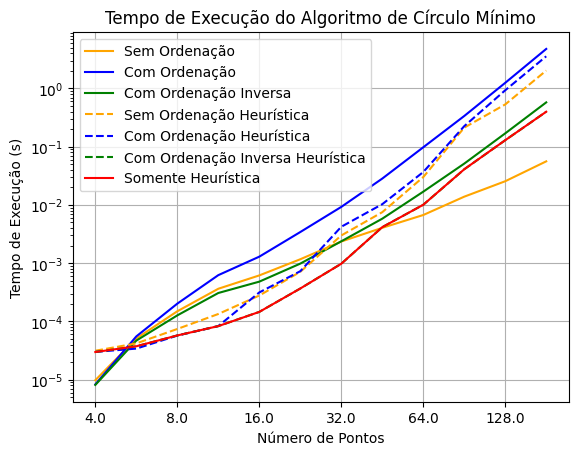

In [12]:
fig, ax = plt.subplots()
ax.plot(rand_mean, label='Sem Ordenação', color="orange")
ax.plot(ord_mean, label='Com Ordenação', color="blue")
ax.plot(rev_mean, label='Com Ordenação Inversa', color="green")
ax.plot(h_rand_mean, label='Sem Ordenação Heurística', linestyle='--', color="orange")
ax.plot(h_ord_mean, label='Com Ordenação Heurística', linestyle='--', color="blue")
ax.plot(h_rev_mean, label='Com Ordenação Inversa Heurística', linestyle='--', color="green")
ax.plot(h_rev_mean, label='Somente Heurística', color="red")
ax.set_xlabel('Número de Pontos')
ax.set_ylabel('Tempo de Execução (s)')
ax.set_title('Tempo de Execução do Algoritmo de Círculo Mínimo')
ax.set_yscale("log")
ax.set_xticklabels(PG * np.logspace(0,TESTES_VALIDACAO-1, num=TESTES_VALIDACAO, base=PG))
ax.legend()
ax.grid(True)

plt.show()